In [1]:
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path("..").absolute()))
import environment as tse
import torch
import tqdm
import matplotlib.pyplot as plt
from agents.q_agent import DQNActor
from agents.metrics import MovingAverage, MovingTotal
from tensorboard import notebook
from plotting import plot_samplers
from IPython.display import Image, display, clear_output
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
from three_stage_system import ThreeStageSystemDirector
import numpy as np
import imageio





In [2]:
dt  = 10
PARAMS = {
    "torch_device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "environment" : {
        "measurement_time_cost": 1.0,
        "input_cost": 0.01,
        "message_loss_costs": 1.0,
        "dt": dt, # Simulation progresses in steps of 2ms
        "state_normalization": 100
    },
    "systems" : {
        "num_local": 3,
        "num_input_per_local": 4,
        "random_system": {
            "global_sampler" : tse.GammaDistributionSampler(20.0, 0.5, 2.5, 60.0),
            "local_sampler" : tse.GammaDistributionSampler(12.0, 1.0, 1.0, 20.0),
            "input_proc_sampler" : tse.GammaDistributionSampler(12.0, 1.0, 2.0, 30.0),
            "input_sens_sampler" : tse.GaussianTimeSampler(5, 3, 0, 20)
        },
        "deterministic_system" : {
            "global_sampler": tse.FixedTime(90),
            "local_sampler": tse.FixedTime(30),
            "input_proc_sampler": tse.FixedTime(50),
            "input_sens_sampler": tse.FixedTime(0),
        }
    },
    "actor" : {
        "learn_period": int(100 / dt), # Update model every 100ms
        "memory_size": 2 * 60 * int(1_000 / dt), # Memory spans a period of 2 minutes,
        "tau" : dt / 2000.0, # Full model update after 2sec
        "batch_size" : 1024, # Number of samples used in one optimization
        "gamma": 0.9, # Hyperparam; not really of used in continuous task
        "epsilon_start": 0.1,
        "epsilon_end": 0.0,
        "epsilon_decay" : 4 * 60 * int(1_000 / dt), # Half-life of epsilon decay: 4 minutes
        "lr" : 1e-3,
    },
    "num_sim_steps": int(3_600_000 / dt) # train for 1h
}


In [3]:
clock = tse.Clock(0)
builder_director = ThreeStageSystemDirector(clock.as_readonly())

Set-up a "randomized" environment with stochastic execution times. Refer to the graph diagram for the overall system architecture. Processing times follow gamma distributions (that is each time a computing task starts, its execution time is sampled from a gamma distribution).

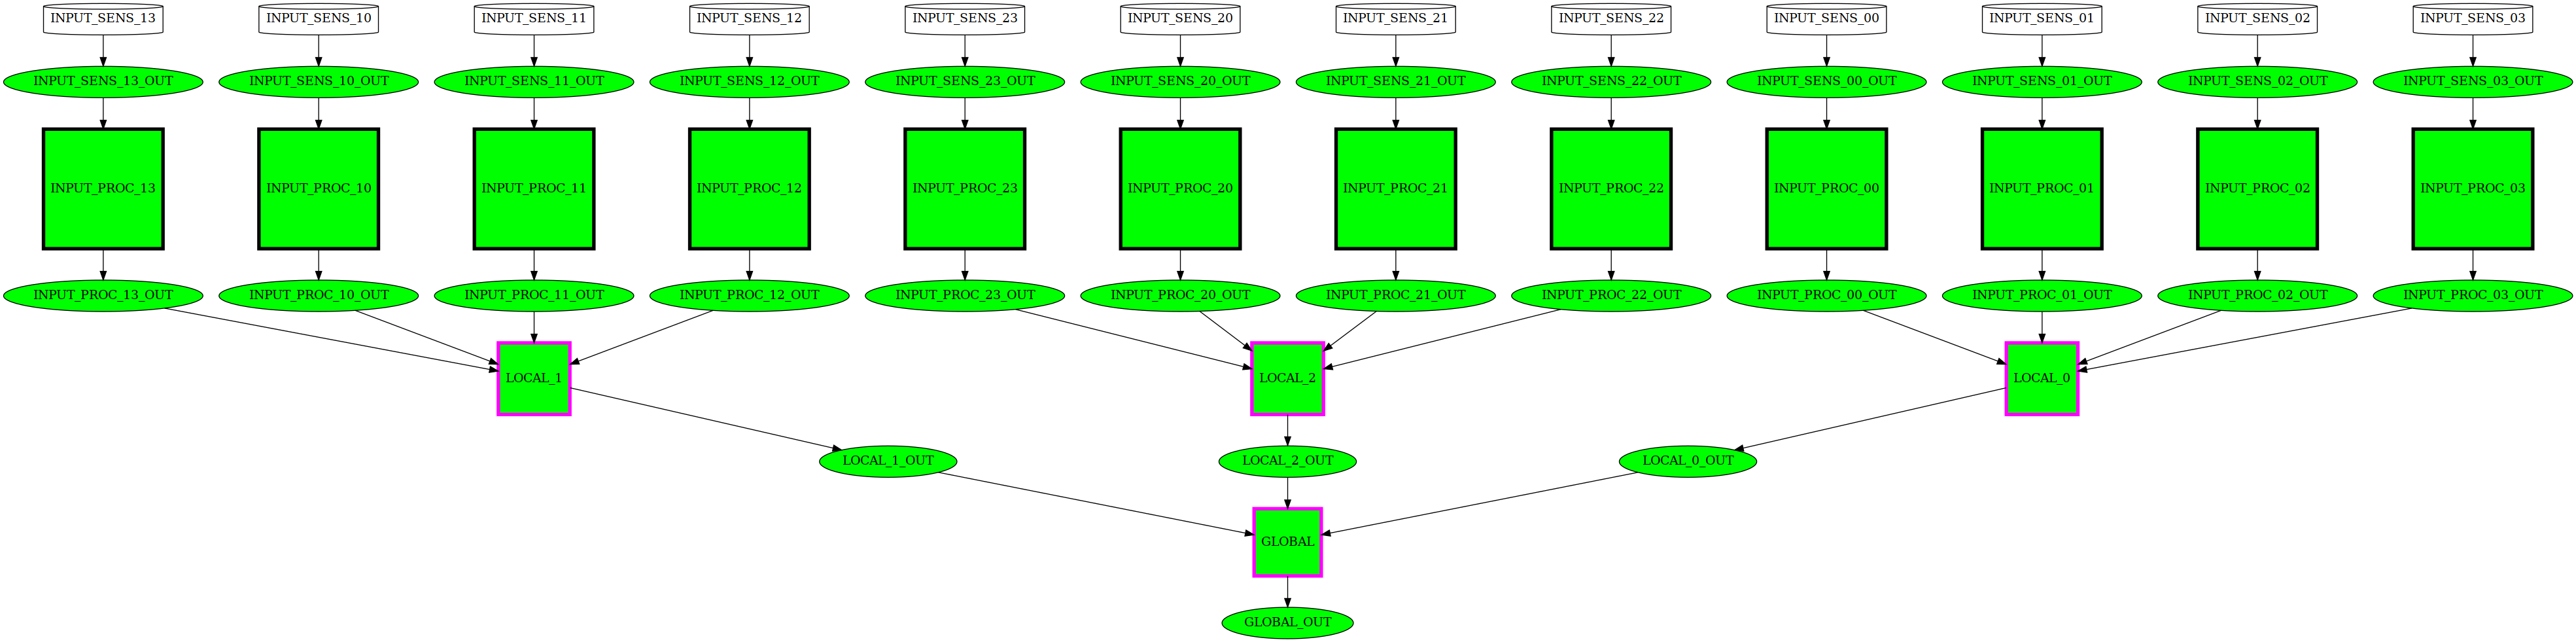

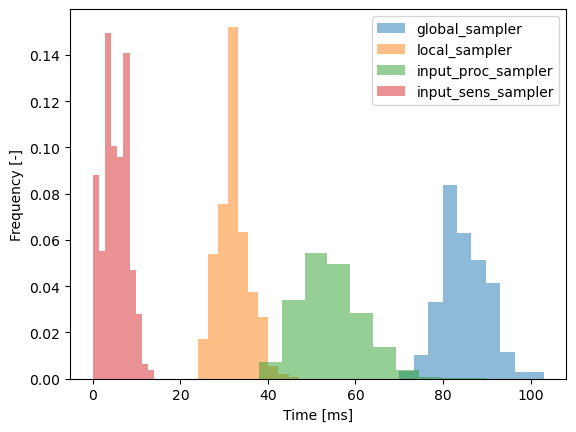

In [4]:
# First, let's define some execution time samplers and plot them
fig, ax = plt.subplots(1, 1)
plot_samplers(ax, PARAMS["systems"]["random_system"], N = 1_000, num_bins=10)

# Then build the system and plot its structure
random_system = builder_director.build_simple_system(
    num_local=PARAMS["systems"]["num_local"],
    num_input_per_local=PARAMS["systems"]["num_input_per_local"],
    **PARAMS["systems"]["random_system"]
)

env_random = tse.TimeSchedulingEnv(
    clock, random_system, **PARAMS["environment"]
)
## Plot the system hierarchy
data = tse.draw_system(env_random._system, format="png")
display(Image(data, width=1200))



We also add a deterministic environment. The system architecture is the same as in the random-system case. Execution times are deterministic, however.

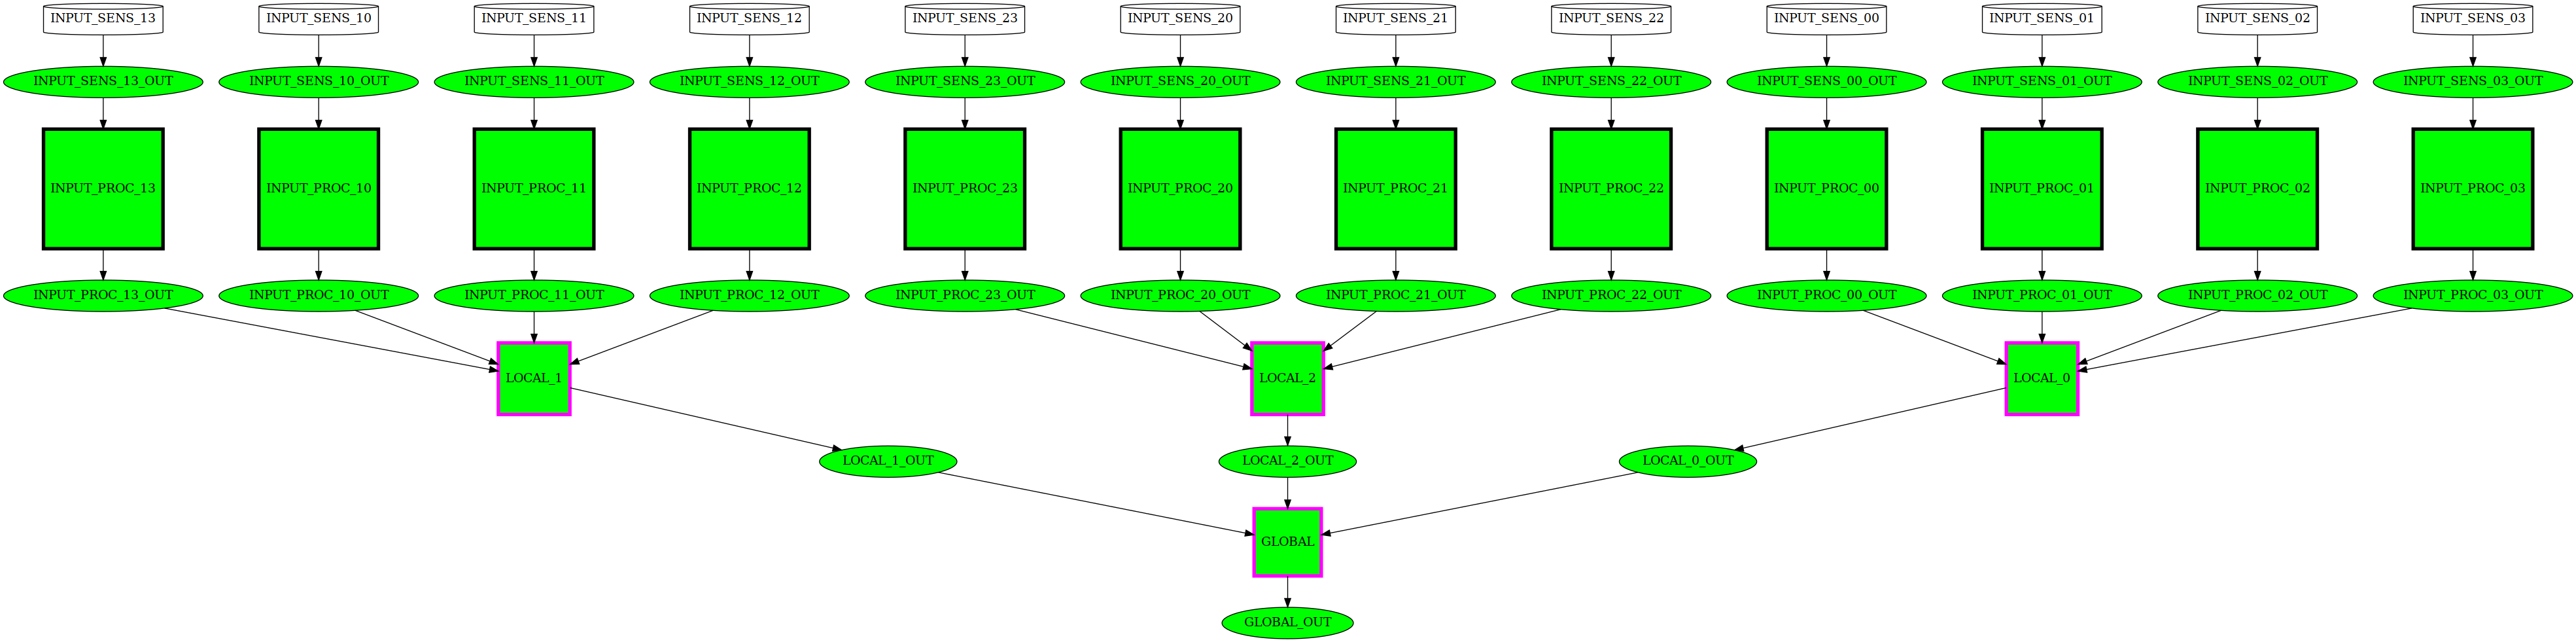

In [5]:
# Then build the system and plot its structure
deterministic_system = builder_director.build_simple_system(
    num_local=PARAMS["systems"]["num_local"],
    num_input_per_local=PARAMS["systems"]["num_input_per_local"],
    **PARAMS["systems"]["deterministic_system"]
)
env_deterministic= tse.TimeSchedulingEnv(
    clock, deterministic_system, **PARAMS["environment"]
)

# Plot the system hierarchy
data = tse.draw_system(env_deterministic._system, format="png")
display(Image(data, width=1200))

In [6]:
# Instantiate actors
actor_deterministic = DQNActor(
    env_deterministic.observation_space.shape[0],
    env_deterministic.action_space.n,
    device=PARAMS["torch_device"],
    **PARAMS["actor"]
)
actor_random = DQNActor(
    env_deterministic.observation_space.shape[0],
    env_deterministic.action_space.n,
    device=PARAMS["torch_device"],
    **PARAMS["actor"]
)

In [7]:
def train(
    actor: DQNActor,
    env: tse.TimeSchedulingEnv,
    num_sim_steps: int,
    learn_period: int,
    num_samples_metrics_filter: int,
    num_skip_logging: int = 20,
    writer=None,
    device: str = "cpu",
):
    # Prepare filters for metrics
    avg_message_loss = MovingTotal(num_samples_metrics_filter)
    avg_min = MovingAverage(num_samples_metrics_filter)
    avg_avg = MovingAverage(num_samples_metrics_filter)
    avg_max = MovingAverage(num_samples_metrics_filter)
    avg_reward = MovingAverage(num_samples_metrics_filter)

    # Initialize the environment
    state, _ = env.reset()
    state = torch.tensor(state.data, dtype=torch.float32, device=device).unsqueeze(0)

    # Run training loop
    bar = tqdm.tqdm(range(num_sim_steps))
    for i_step in bar:
        #bar.set_description(f"Time: {env.time} ms")
        # Take action, observe transition
        action = actor.epsilon_greedy(state)
        next_state, reward, _, _, info = env.step(action)

        # Push logging
        avg_message_loss.push(info["total_message_losses"])
        avg_min.push(env.last_output_min_age)
        avg_avg.push(env.last_output_avg_age)
        avg_max.push(env.last_output_max_age)
        avg_reward.push(reward)
        if i_step % num_skip_logging == 0:
            writer.add_scalar("AVG/reward", avg_reward.value, env.time)
            writer.add_scalar("AVG/outputMinTime", avg_min.value * 100, env.time)
            writer.add_scalar("AVG/outputAvgTime", avg_avg.value * 100, env.time)
            writer.add_scalar("AVG/outputMaxTime", avg_max.value * 100, env.time)
            writer.add_scalar("AVG/messageLoss", avg_message_loss.value, env.time)

        # Update memory
        action = torch.tensor([[action]], device=device, dtype=torch.int64)
        next_state = torch.tensor(
            next_state.data, dtype=torch.float32, device=device
        ).unsqueeze(0)
        reward = torch.tensor([reward], device=device)
        actor.push_memory(state, action, next_state, reward)

        # Run learning algo
        if i_step % learn_period == 0:
            learning_info = actor.optimize_model()

        # Log learning stuff
        if i_step % num_skip_logging and "loss" in learning_info:
            writer.add_scalar("Learning/Loss", learning_info["loss"], env.time)
        if i_step % num_skip_logging and "epsilon" in learning_info:
            writer.add_scalar("Learning/Epsilon", learning_info["epsilon"], env.time)

        # Close loop
        state = next_state

        

Run `tensorboard --logdir notebooks/data/01_scheduling_basic_dqn/train` to see training metrics in RT in your browser.

In [8]:
writer = SummaryWriter(log_dir="data/01_scheduling_basic_dqn/train/deterministic")
train(
    actor_deterministic,
    env_deterministic,
    PARAMS["num_sim_steps"],
    PARAMS["actor"]["learn_period"],
    int(5_000 / dt),
    int(200 / dt),
    writer=writer,
    device=PARAMS["torch_device"],
)
writer.flush()
torch.save(actor_deterministic.policy_net.state_dict(), "data/01_scheduling_basic_dqn/model_deterministic.mdl")
writer = SummaryWriter(log_dir="data/01_scheduling_basic_dqn/train/random")
train(
    actor_random,
    env_random,
    PARAMS["num_sim_steps"],
    PARAMS["actor"]["learn_period"],
    int(5_000 / dt),
    (200 / dt),
    writer=writer,
    device=PARAMS["torch_device"],
)
writer.flush()
torch.save(actor_random.policy_net.state_dict(), "data/01_scheduling_basic_dqn/model_random.mdl")

  2%|▏         | 5570/360000 [00:02<02:48, 2104.89it/s]


KeyboardInterrupt: 

In [9]:
actor_deterministic.load_weights("data/01_scheduling_basic_dqn/model_deterministic.mdl")
actor_deterministic.eval()
actor_random.load_weights("data/01_scheduling_basic_dqn/model_random.mdl")
actor_random.eval()

In [10]:
def simulate(actor: DQNActor, env: tse.TimeSchedulingEnv, num_steps: int, device: str="cpu", plotter: tse.SystemStatePlot = None, video_path = None, show = False):
    images = []
    state, _ = env.reset()
    state = torch.tensor(state.data, dtype=torch.float32, device=device).unsqueeze(0)
    for i in range(num_steps):
 
        if env.time % 10 == 0:
            action = actor.greedy(state).item()
        else:
            action = 0

        if plotter:
            plotter.update(env.time, env.unpack_action(action), env._system.get_state())

        next_state , reward, _, _, info = env.step(action)
        state = torch.tensor(next_state.data, dtype=torch.float32, device=device).unsqueeze(
            0
        )

        
        print(f"Time: {env.time}")
        if video_path or show:
            data = tse.draw_system(env._system, format="png")
            if video_path:
                images.append(imageio.imread(data))
            if show:
                display(Image(data, width=1200))
        clear_output(wait=True)
    
    if video_path:
        with imageio.get_writer(video_path) as writer:
            for img in images:
                writer.append_data(img)
    

       

We now run inference on both environments (we instantiated new envs such that we can use a lower value for `dt`, which gives nicer plots!). If you want to visualize the system in real-time, set `show=True` (the viz is a bit slow, but gives some more insitghts into the internal workings of the system). The plots below summarize buffer/node occupancy over time. The red bars indicate at what points in time a compute node or buffer was busy/occupied. Also, the plot shows at what points in time a compute task was triggered (`*_ACT` tasks). 

[]

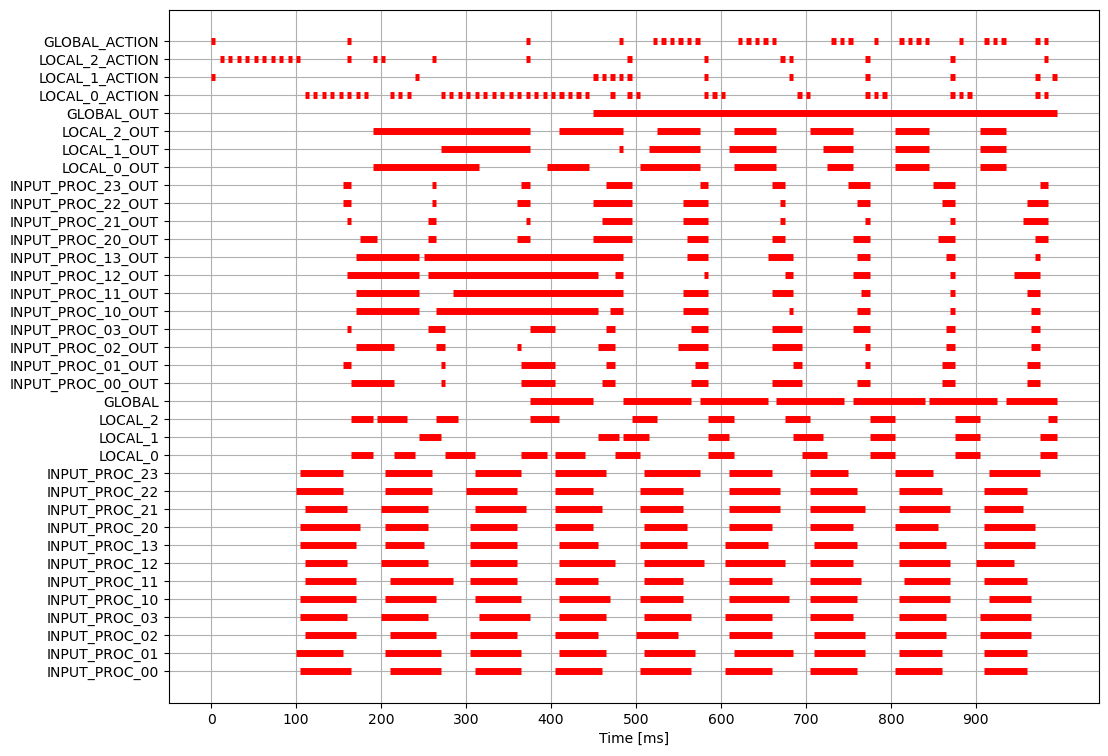

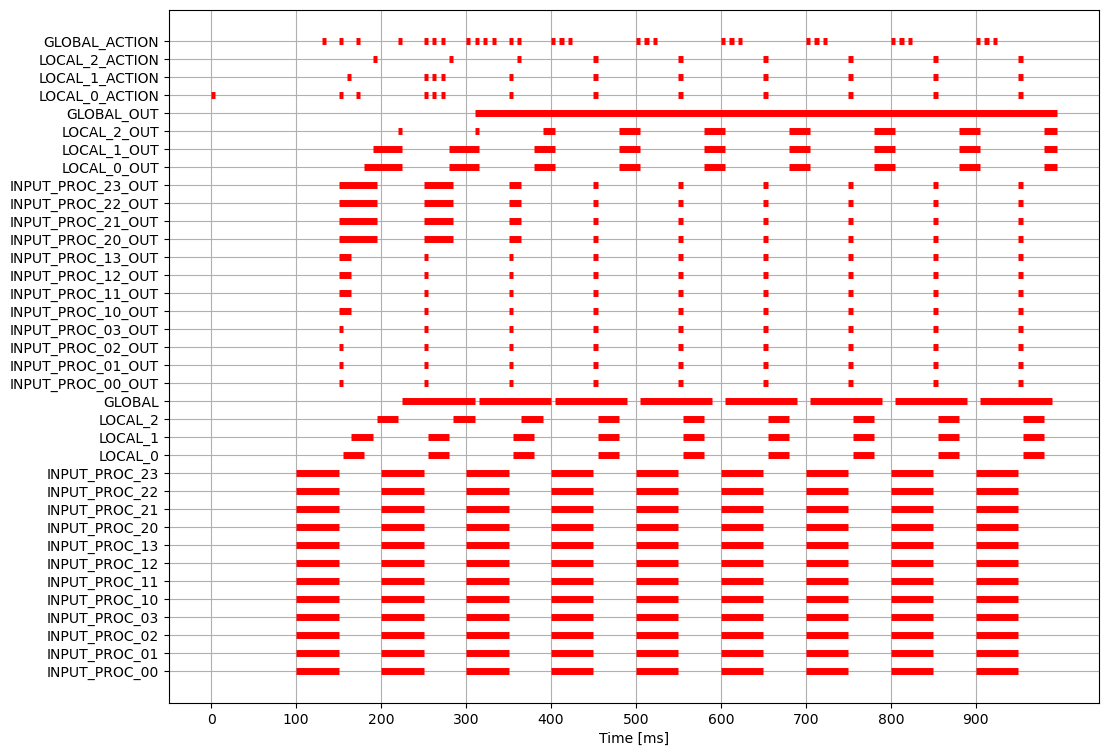

In [12]:
dt = 5
env_params_cpy = PARAMS["environment"].copy()
env_params_cpy["dt"] = dt
env_sim_random = tse.TimeSchedulingEnv(
    clock,
    random_system,
    **env_params_cpy
)
env_sim_deterministic = tse.TimeSchedulingEnv(
    clock,
    deterministic_system,
    **env_params_cpy
)

random_state_plotter = tse.SystemStatePlot(env_sim_random._system) 
simulate(actor_random, env_sim_random, int(1000 / dt), device=PARAMS["torch_device"], plotter = random_state_plotter, video_path="data/01_scheduling_basic_dqn/random.gif", show = False)

deterministic_state_plotter = tse.SystemStatePlot(env_sim_deterministic._system) 
simulate(actor_deterministic, env_sim_deterministic, int(1000 / dt), device=PARAMS["torch_device"], plotter = deterministic_state_plotter, video_path="data/01_scheduling_basic_dqn/deterministic.gif", show = False)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((12, 9))
random_state_plotter.plot(ax)
ax.plot()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((12, 9))
deterministic_state_plotter.plot(ax)
ax.plot()

![](random.gif)